# DBScan Feature Extraction for PEX Pipe

In [14]:
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from os import listdir
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

## Functions

In [15]:
def IR_PCA(input_data, PCs):
    """
    Perform a principle component analysis on a single IR dataset. 
    This function is meant to be used on a dataset containing a single sample.
    It returns the dataframe of the transformed data, the loading dataframe, 
    and the PCA model itself. 
    """
    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)
    
    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
    
    return(PC_df, loadings_df, pca_model)

def IR_DBSCAN(input_data, eps, min_samples):
    """TO BE COMPLETED 
    Perform a density based scan on the provided data. 

    Built for doing DBScan on PCA data of the PEX-a pipe spectral changes. 
    """
    # Apply DBSCAN
    db = DBSCAN(eps, min_samples).fit(input_data)

    labels = db.labels_
    # Get number of cores and features, cores should be two for the PEX samples 
    numberOfCores, numberOfFeautures = db.components_

    return(db, labels, numberOfFeautures, numberOfCores)

def trainPCAModel(path, trainingFiles, PCs, modelName):
    """
    Train a principle component model and save it to a pickle file. 

    path: Filepath to the data that will be used to train the PCA model. 
    trainingFiles: Filesname for the data that will be used to train the PCA model. 
    modelName: The filename of the pickle file that will contain the PCA model. 
    """
    input_data = pd.concat([pd.read_csv(path+file) for file in trainingFiles])

    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)

    # Save the model to a pickle file
    if modelName.endswith('.pkl'):
        with open(modelName, 'wb') as f:
            pickle.dump(pca_model, f)
            f.close
    else: 
        with open(modelName+'.pkl', 'wb') as f:
            pickle.dump(pca_model, f)
            f.close

    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))

    return PC_df, loadings_df

def distribution_Selection(df, distributionIdx, numberOfSigmas):
    """
    Screens data based on the distribution of a given column in a pandas dataframe. 
    Built for screening out dataset values that do not have a sufficient 2019 wavenumber 
    integral for the PEX project. Can be modified to projects liking. 

    Returns the selected datas indexes, the discarded indexes, the mask used to select the data,
    the x position of the distribution mode, and the column values of the distribution that is
    being used to screen data. In this case the values of the baseline integral of the PE 2019
    wavenumber peak. 
    """
    
    df[distributionIdx] = df[distributionIdx].astype(float)

    #creating variable for the array of Polyethylene Area
    area = df['1981.7 - 2095.8'].values

    # Use Gaussian KDE to find the center position of the rightmost mode by creating x coords
    # and then using np.argmax to determine the point with the highest number of counts
    kde = gaussian_kde(area)
    xs = np.linspace(area.min(), area.max(), 1000) 
    modePosition = xs[np.argmax(kde(xs))]

    # Use only the values greater than 1.5 to determine the std of the PE peaks
    positive_vals = area[area > 1.5]
    sigma = positive_vals.std()

    lowerDistributionBound = modePosition - numberOfSigmas * sigma
    upperDistributionBound = modePosition + numberOfSigmas * sigma

    # Select the range of PE normalization integral to be accepted by the mask
    mask_selected = (area >= lowerDistributionBound) & (area <= upperDistributionBound)
    selected_indexes = df.index[mask_selected]
    discarded_indexes = df.index[~mask_selected]

    return selected_indexes, discarded_indexes, mask_selected, modePosition, area

def roundWavenumbers(dataframe):
    """
    Function for rounding the wavenumbers so that there is no mismatch between the machine 
    precision of saving the files in Quasar and the wavenumbers output by the FTIR microscope
    """
    last_nonwavenum_idx = dataframe.columns.get_loc('1981.7 - 2095.8') + 1

    dataframe = dataframe.rename(columns=lambda c: round(float(c), 1) if c not in dataframe.columns[:last_nonwavenum_idx] else c)
    return dataframe


## Manage the Dataset

Files to test the PCA model on:
 ['SMP65#013 0d 420um.csv', 'SMP65#013 7d 420um.csv', 'SMP65#013 14d 420um.csv', 'SMP65#013 21d 420um.csv', 'SMP65#013 28d 420um.csv']
Files to train the PCA model on:
 ['SMP65#010 7d 800um full width.csv', 'SMP65#010 14d 800um full width.csv', 'SMP65#010 21d 800um full width.csv', 'SMP65#010 28d 800um full width.csv', 'SMP65#010 42d 800um full width.csv', 'SMP65#010 56d 800um full width.csv', 'SMP65#010 70d 800um full width.csv', 'SMP65#010 84d 800um full width.csv', 'SMP65#010 100d 800um full width.csv']
          map_x    map_y Sample Name  1981.7 - 2095.8  1799.4    1797.8  \
0       39489.8  23216.6    7d 800um        -0.010594       0  0.015104   
1       39495.2  23216.6    7d 800um        -0.000621       0  0.000000   
2       39500.7  23216.6    7d 800um         0.130859       0  0.028649   
3       39506.1  23216.6    7d 800um         0.057046       0  0.010930   
4       39511.5  23216.6    7d 800um         0.260166       0  0.119295   
...   

(-1.0, 5.472319219219223)

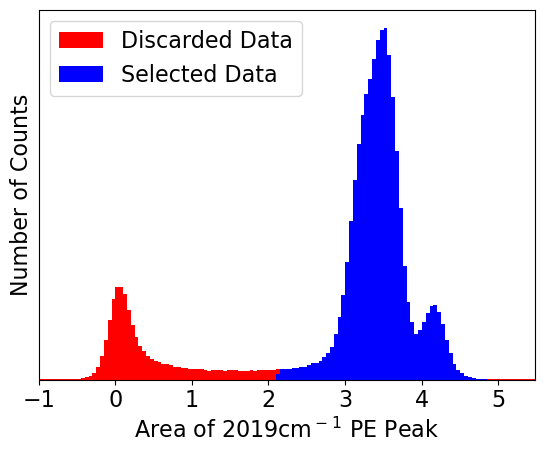

In [20]:
"""
Here we are choosing that dataset that we are going to look at using the PCA model
"""

path ='../data/'
filename = path + 'SMP65#013 7d 420um'
filename += '.csv'

test_df = pd.read_csv(filename)

# Create an array of strings containing the wavenumbers
test_df = roundWavenumbers(test_df)

# Obtain the last Index before starting wavenumbers, this may change depending on data
last_nonwavenum_idx = test_df.columns.get_loc('1981.7 - 2095.8') + 1

wavenumbers = test_df.columns[last_nonwavenum_idx:]
#print(wavenumbers)

allFiles = listdir(path)

testFiles = [file for file in allFiles if 'SMP65#013' in file and file.endswith('.csv') and '420um' in file]
testFiles = sorted(testFiles, key=lambda x: int(re.search(r'(?<= )(.+?)(?=d)', x).group()))
print(f'Files to test the PCA model on:\n {testFiles}')
testDataframeList = [pd.read_csv(path+file) for file in testFiles]

"""
This part is for training PCA on multiple datasets
"""

#List all of the files in the data directory.
allFiles = listdir(path)
# Take only the files that contain data pertaining to SMP65#010 
trainingFiles = [file for file in allFiles if 'SMP65#010' in file and file.endswith('.csv') and 'full width' in file]

trainingFiles = sorted(trainingFiles, key=lambda x: int(re.search(r'(?<= )(.+?)(?=d)', x).group()))

print(f'Files to train the PCA model on:\n {trainingFiles}')

# Read all of the data and place the dataframes into a list
trainingDataframeList = [pd.read_csv(path+file) for file in trainingFiles]

# Lambda function to round all of the wavenumbers so that they are all matching, and then concatenate all the datasets together

rawTrainingDataframe = pd.concat(
    (
        df.rename(
            columns=lambda c: round(float(c), 1) if c not in df.columns[:last_nonwavenum_idx] else c
        )
        for df in trainingDataframeList
    ),
    ignore_index=True
)

#rawTrainingDataframe['aged_time'] = rawTrainingDataframe['Sample Name'].str.strip().str.extract(r'(\d+)').astype(int)

# Sort by the extracted numeric value
#rawTrainingDataframe = rawTrainingDataframe.sort_values('aged_time').drop(columns='aged_time').reset_index()

wavenumbers = rawTrainingDataframe.columns[last_nonwavenum_idx:]
#print(wavenumbers)

selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(rawTrainingDataframe, '1981.7 - 2095.8', 3)

print(rawTrainingDataframe)

bin_width = 0.05
bins = np.arange(min(areaPE), max(areaPE) + bin_width, bin_width)

plt.hist(areaPE,bins=bins, color='r')
plt.hist(areaPE[mask_selected], bins=bins, color='b')
plt.yticks([])
plt.xticks(fontsize=16)
plt.ylabel('Number of Counts', fontsize=16)
plt.xlabel(f'Area of 2019cm$^-$$^1$ PE Peak', fontsize=16)
plt.legend(['Discarded Data', 'Selected Data'], fontsize=16, loc='upper left')
plt.xlim([-1, modePosition + 2])

# Perform the PCA Analysis and Plot Loading Spectra

Explained variation per principal component: [0.84752171 0.08593471 0.02112834]
Raw Dataset shape:  (442368, 505) Filtered Dataset shape:  (363092, 505)


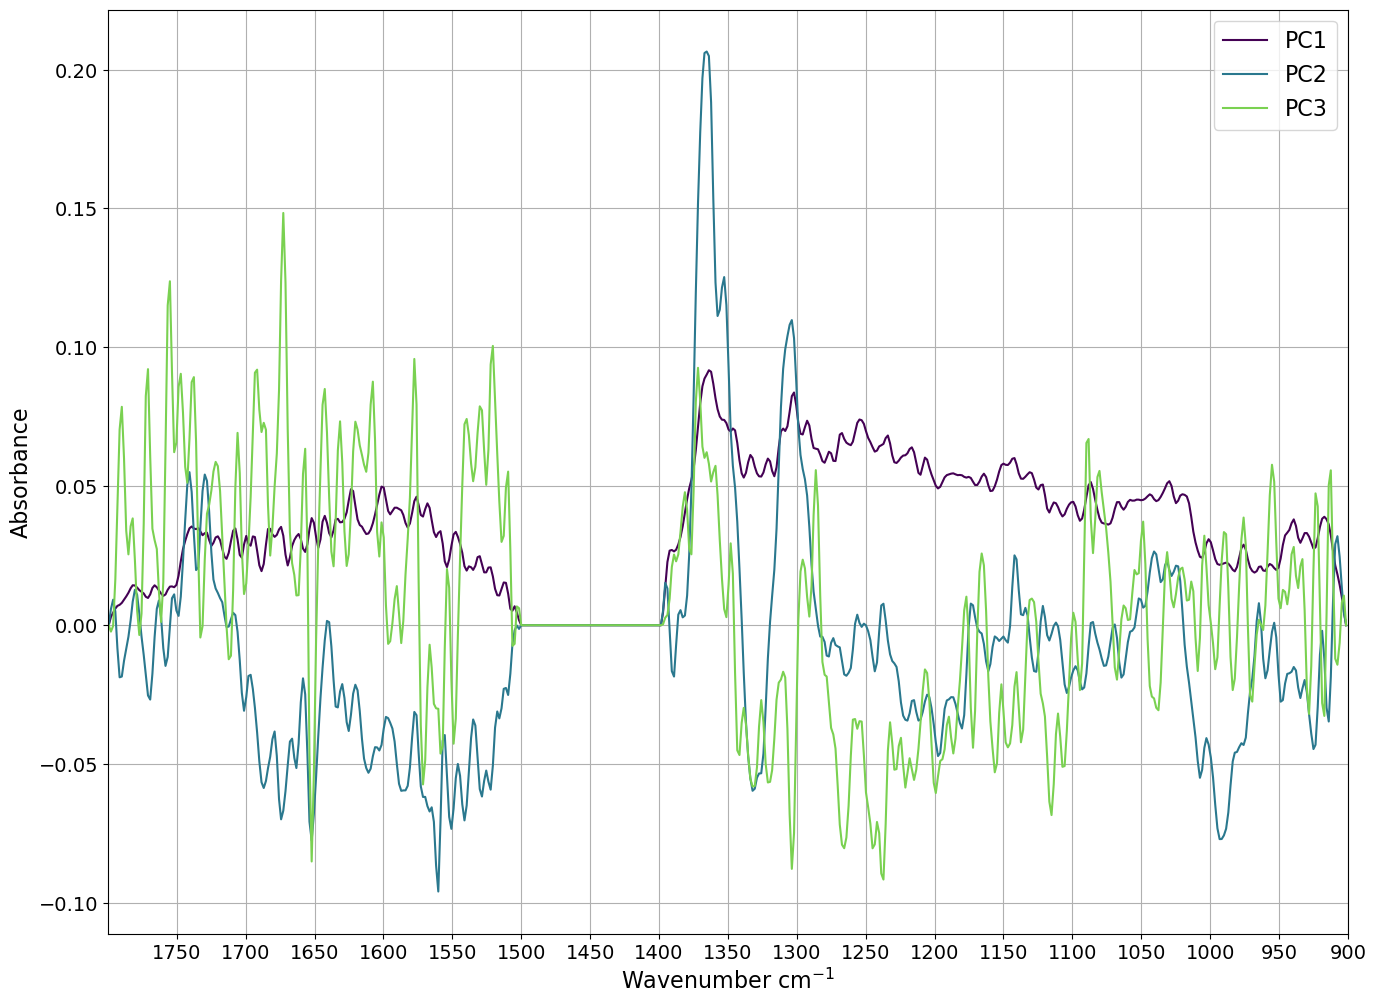

In [21]:
PCs = 3
# Create dataset containing ONLY the wavenumbers
rawData = rawTrainingDataframe[wavenumbers].copy()

# Modify created dataset to contain ONLY the masked values
masked_PC_inputData = rawData[mask_selected].values

# Train a PCA model on the masked values 
PCA_df_init, loadings_df_init, pca_model = IR_PCA(masked_PC_inputData, PCs=PCs)

print("Raw Dataset shape: ", rawData.shape, "Filtered Dataset shape: ", masked_PC_inputData.shape)

# Save the model to a pickle file
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)
# Open the same model
with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)

testDataframeTransformed = []

for df in testDataframeList:

    df = roundWavenumbers(df)
    
    selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(df, '1981.7 - 2095.8', 3)

    PC_data = df[wavenumbers].copy()

    # Use the model again on the unmasked values to get the same result for the complete dataset
    data_PCs = loaded_pca_model.transform(PC_data.values)
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]

    transformed_df = pd.DataFrame(data = data_PCs[mask_selected], columns = columns_list)

    transformed_df['Aging Times'] = df['Sample Name']

    testDataframeTransformed.append(transformed_df)


testDataframeTransformed = pd.concat(testDataframeTransformed)

selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(test_df, '1981.7 - 2095.8', 3)

rawTestData = test_df[wavenumbers].copy()

# Use the model again on the unmasked values to get the same result for the complete dataset
data_PCs = loaded_pca_model.transform(rawTestData.values)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs[mask_selected], columns = columns_list)

#PCA_df = data_PCs[mask_selected]

PCA_df['map_x'] = test_df['map_x'].reindex
PCA_df['map_y'] = test_df['map_y'].reindex
PCA_df['Aging Times'] = test_df['Sample Name']

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, PCs))

plt.figure(figsize=(16,12))
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16)
plt.ylabel('Absorbance', fontsize=16)
plt.xticks(np.arange(900, 1800, step=50), fontsize=14)
plt.yticks(fontsize=14)
for i in range(PCs):
    #loadings = savgol_filter(loadings_df_init.iloc[i, :].values, 9, 3)
    loadings = loadings_df_init.iloc[i, :].values
    plt.plot(
        wavenumbers,
        loadings,
        color=colors[i],
        label=f"PC{i+1}"
    )

legend_labels = [f'PC{i+1}' for i in range(PCs)]
plt.legend(legend_labels, fontsize=16, loc='upper right')
#plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.grid()
plt.xlim(1800, 900)
plt.savefig("PCs_loading_spectrum.png", dpi=900)


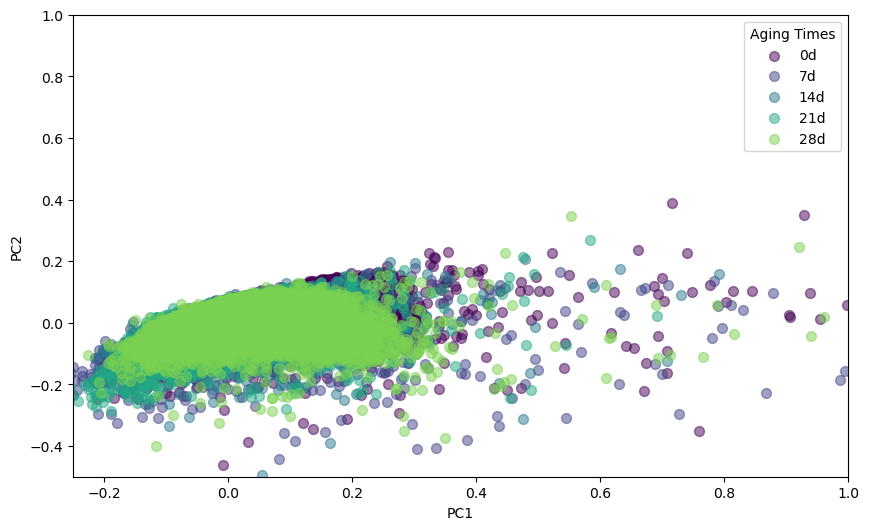

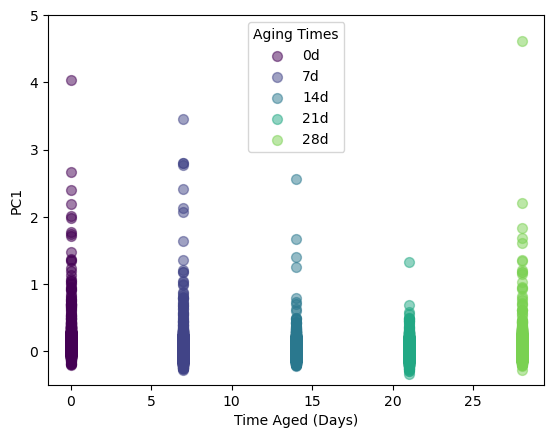

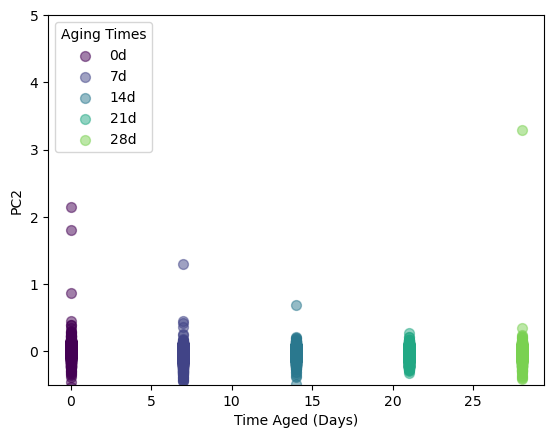

<Figure size 640x480 with 0 Axes>

In [22]:
"""
SCATTER PLOTS OF PCAs

Plot two PCs against each other and color by aging time to see how they vary
"""
colour_list=[]
plt.figure(figsize=(10,6))
unique_samples = testDataframeTransformed['Aging Times'].unique()
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(unique_samples)))
i=0
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    plt.scatter(subset['PC1'].values, subset['PC2'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('PC1')
plt.xlim((-.25, 1))
plt.ylabel('PC2')
plt.ylim((-0.5, 1))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)

"""
Principal Component One versus Aging time
"""

i=0
unique_samples_int = [int(sample.split(' ')[0][:-1]) for sample in unique_samples]
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    aged_time = [int(string.split(' ')[0][:-1]) for string in subset['Aging Times']]

    plt.scatter(aged_time, subset['PC1'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('Time Aged (Days)')
#plt.xlim((-.25, 1))
plt.ylabel('PC1')
plt.ylim((-0.5, 5))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)

"""
Principal Component Two versus Aging time
"""

i=0
unique_samples_int = [int(sample.split(' ')[0][:-1]) for sample in unique_samples]
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    aged_time = [int(string.split(' ')[0][:-1]) for string in subset['Aging Times']]

    plt.scatter(aged_time, subset['PC2'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('Time Aged (Days)')
#plt.xlim((-.25, 1))
plt.ylabel('PC2')
plt.ylim((-0.5, 5))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)


"""
Plot three PCs in a meshgrid and color by aging time
"""
if False: 
    PC1 = PCA_df['PC1'].to_numpy() 
    PC2 = PCA_df['PC2'].to_numpy()
    PC3 = PCA_df['PC3'].to_numpy()

    X, Y, Z = np.meshgrid(PC1[::100], PC2[::100], PC3[::100])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, cmap='viridis')
    plt.show()


# Plotting the PCA Spatial Analysis

Preparing data for plottings

In [23]:
PC1 = PCA_df['PC1'].to_numpy()
PC2 = PCA_df['PC2'].to_numpy()
PC3 = PCA_df['PC3'].to_numpy()

#Reposition the mapping to start at 0,0 
Map_x = test_df['map_x'].to_numpy()
Map_y = test_df['map_y'].to_numpy()
Map_y2 = []
Map_x2 = []
Min_x = min(Map_x)
Min_y = min(Map_y)

Map_x2 = Map_x - Min_x
Map_y2 = Map_y - Min_y

x_adjusted=(np.unique(Map_x2)).tolist()
y_adjusted=(np.unique(Map_y2)).tolist()

X, Y = np.meshgrid(x_adjusted, y_adjusted)

Xsize, Ysize = len(x_adjusted), len(y_adjusted)
print("Length of X, Y: ", Xsize, Ysize, "\n")

print("Length of X*Y: ",len(x_adjusted)*len(y_adjusted), "\n")

print("Lenght of PC1: ", len(PC1), "Legnth of PC2: ", len(PC2), "\n")
# Format PC1 for plotting
PC1resized = np.reshape(PC1, (Ysize, Xsize))

# Format PC2 for plotting
PC2resized = np.reshape(PC2, (Ysize,Xsize))

# Format PC2 for plotting
PC3resized = np.reshape(PC3, (Ysize,Xsize))




Length of X, Y:  384 128 

Length of X*Y:  49152 

Lenght of PC1:  40971 Legnth of PC2:  40971 



ValueError: cannot reshape array of size 40971 into shape (128,384)

Creating Figures and Plotting the PCs

In [ ]:
# Prepare colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(loadings_df_init)))
cmap.set_bad(color='0.7')  # dull grey for masked values

# Setting up the mask for plotting
PC1_masked = np.ma.array(PC1resized, mask=~mask_selected)
PC2_masked = np.ma.array(PC2resized, mask=~mask_selected)
PC3_masked = np.ma.array(PC3resized, mask=~mask_selected)

"""
Plotting the first Principal Component
"""

fig1, ax1 = plt.subplots(figsize=(8, 6))

im1 = ax1.pcolormesh(X, Y, PC1_masked, cmap='bwr', shading='auto')
im1.set_clim(-0.3, 0.3)

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC1', fontsize=14)

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

"""
Plotting the second Principal Component 
"""

fig2, ax2 = plt.subplots(figsize=(8, 6))

im2 = ax2.pcolormesh(X, Y, PC2_masked, cmap='bwr', shading='auto')
im2.set_clim(-0.3, 0.3)

cbar = fig2.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC2', fontsize=14)

ax2.set_aspect('equal')

ax2.set_xticks([])
ax2.set_yticks([])

if PCs > 2:
    fig3, ax3 = plt.subplots(figsize=(8, 6))

    im3 = ax3.pcolormesh(X, Y, PC3_masked, cmap='bwr', shading='auto')
    im3.set_clim(-0.3, 0.3)
    
    cbar = fig3.colorbar(im3, ax=ax3)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(r'PC3', fontsize=14)

    ax3.set_aspect('equal')

    ax3.set_xticks([])
    ax3.set_yticks([])


NameError: name 'PC1resized' is not defined

## Density Based Scan for Different 